In [465]:
import pandas as pd
import numpy as np
from lifelines import CoxPHFitter
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split

In [486]:
# 📌 1. Wczytanie danych
train_df = pd.read_csv("train.csv")
data_dict_df = pd.read_csv("data_dictionary.csv")

In [487]:
# 📌 3. Usunięcie kolumn z dużą liczbą braków (>50%)
missing_values = train_df.isnull().sum()
threshold = len(train_df) * 0.5
columns_to_drop = missing_values[missing_values > threshold].index.tolist()
train_df.drop(columns=columns_to_drop, inplace=True)

In [488]:
# 📌 2. Identyfikacja zmiennych kategorycznych i numerycznych
categorical_cols = [col for col in train_df.columns if col in data_dict_df[data_dict_df["type"] == "Categorical"]["variable"].tolist()]
numerical_cols = [col for col in train_df.columns if col in data_dict_df[data_dict_df["type"] == "Numerical"]["variable"].tolist()]

In [489]:
# 📌 4. Uzupełnienie brakujących wartości
# Numeryczne → medianą
num_imputer = SimpleImputer(strategy="median")
train_df[numerical_cols] = num_imputer.fit_transform(train_df[numerical_cols])

In [490]:
# Kategoryczne → najczęstszą wartością
categorical_cols.remove('efs')
cat_imputer = SimpleImputer(strategy="most_frequent")
train_df[categorical_cols] = cat_imputer.fit_transform(train_df[categorical_cols])
categorical_cols.append('efs')

In [491]:
train_df[categorical_cols]

,dri_score,psych_disturb,cyto_score,diabetes,tbi_status,arrhythmia,graft_type,vent_hist,renal_issue,pulm_severe,...,rheum_issue,sex_match,race_group,hepatic_mild,tce_div_match,donor_related,melphalan_dose,cardiac,pulm_moderate,efs
0,N/A - non-malignant indication,No,Poor,No,No TBI,No,Bone marrow,No,No,No,...,No,M-F,More than one race,No,Permissive mismatched,Unrelated,"N/A, Mel not given",No,No,0.0
1,Intermediate,No,Intermediate,No,"TBI +- Other, >cGy",No,Peripheral blood,No,No,No,...,No,F-F,Asian,No,Permissive mismatched,Related,"N/A, Mel not given",No,Yes,1.0
2,N/A - non-malignant indication,No,Poor,No,No TBI,No,Bone marrow,No,No,No,...,No,F-M,More than one race,No,Permissive mismatched,Related,"N/A, Mel not given",No,No,0.0
3,High,No,Intermediate,No,No TBI,No,Bone marrow,No,No,No,...,No,M-M,White,Yes,Permissive mismatched,Unrelated,"N/A, Mel not given",No,No,0.0
4,High,No,Poor,No,No TBI,No,Peripheral blood,No,No,No,...,No,M-F,American Indian or Alaska Native,No,Permissive mismatched,Related,MEL,No,No,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28795,Intermediate - TED AML case <missing cytogenetics,No,Favorable,No,No TBI,No,Peripheral blood,No,No,No,...,No,M-F,More than one race,No,Bi-directional non-permissive,Related,"N/A, Mel not given",No,No,0.0
28796,High,No,Poor,Yes,No TBI,No,Peripheral blood,No,No,No,...,No,M-F,Native Hawaiian or other Pacific Islander,No,GvH non-permissive,Related,"N/A, Mel not given",Yes,Yes,1.0
28797,TBD cytogenetics,No,Poor,No,No TBI,No,Peripheral blood,No,No,No,...,No,M-F,Native Hawaiian or other Pacific Islander,No,GvH non-permissive,Unrelated,"N/A, Mel not given",No,No,0.0
28798,N/A - non-malignant indication,No,Poor,No,No TBI,No,Peripheral blood,No,No,No,...,No,M-M,Black or African-American,No,Permissive mismatched,Related,MEL,No,No,0.0


In [492]:
# Lista kolumn kategorycznych przed One-Hot Encoding
categorical_cols.remove('efs')

# Tworzymy encoder
encoder = OneHotEncoder(drop="first", sparse_output=False, handle_unknown="ignore")

# Dopasowanie i transformacja danych
encoded_array = encoder.fit_transform(train_df[categorical_cols])

# Tworzenie nowych nazw kolumn po OneHotEncoder
encoded_col_names = encoder.get_feature_names_out(categorical_cols)

# Tworzymy nowy DataFrame z zakodowanymi danymi
df_encoded = pd.DataFrame(encoded_array, columns=encoded_col_names, index=train_df.index)

# Usuwamy stare kolumny kategoryczne i dodajemy nowe
train_df = train_df.drop(columns=categorical_cols)
train_df = pd.concat([train_df, df_encoded], axis=1)

# Aktualizacja listy kolumn kategorycznych
categorical_cols = list(df_encoded.columns)

# Dodanie EFS do listy kolumn kategorycznych (jeśli ma być traktowana jako kategoryczna)
categorical_cols.append("efs")

# Sprawdzenie nowej listy kolumn kategorycznych
print(categorical_cols)

['dri_score_High - TED AML case <missing cytogenetics', 'dri_score_Intermediate', 'dri_score_Intermediate - TED AML case <missing cytogenetics', 'dri_score_Low', 'dri_score_Missing disease status', 'dri_score_N/A - disease not classifiable', 'dri_score_N/A - non-malignant indication', 'dri_score_N/A - pediatric', 'dri_score_TBD cytogenetics', 'dri_score_Very high', 'psych_disturb_Not done', 'psych_disturb_Yes', 'cyto_score_Intermediate', 'cyto_score_Normal', 'cyto_score_Not tested', 'cyto_score_Other', 'cyto_score_Poor', 'cyto_score_TBD', 'diabetes_Not done', 'diabetes_Yes', 'tbi_status_TBI + Cy +- Other', 'tbi_status_TBI +- Other, -cGy, fractionated', 'tbi_status_TBI +- Other, -cGy, single', 'tbi_status_TBI +- Other, -cGy, unknown dose', 'tbi_status_TBI +- Other, <=cGy', 'tbi_status_TBI +- Other, >cGy', 'tbi_status_TBI +- Other, unknown dose', 'arrhythmia_Not done', 'arrhythmia_Yes', 'graft_type_Peripheral blood', 'vent_hist_Yes', 'renal_issue_Not done', 'renal_issue_Yes', 'pulm_sever

In [ ]:
# 📌 6. Standaryzacja zmiennych numerycznych
numerical_cols.remove('efs_time')
scaler = StandardScaler()
train_df[numerical_cols] = scaler.fit_transform(train_df[numerical_cols])
numerical_cols.append('efs_time')

In [493]:
# 📌 7. Podział zbioru na **train / validation**
train_set, val_set = train_test_split(train_df, test_size=0.2, random_state=42, stratify=train_df["efs"])

In [494]:
# 📌 8. Trening modelu Cox Proportional Hazards
features = [col for col in train_set.columns if col not in ["ID",'gvhd_proph_FK+- others(not MMF,MTX)', "efs", "efs_time"]]

In [532]:
cox_model = CoxPHFitter(penalizer = 0.005)
cox_model.fit(train_set[features + ["efs_time", "efs"]], duration_col="efs_time", event_col="efs")


<lifelines.CoxPHFitter: fitted with 23040 total observations, 10614 right-censored observations>

In [533]:

# 📌 9. Obliczenie C-Index na zbiorze treningowym i walidacyjnym
c_index_train = cox_model.concordance_index_
c_index_val = cox_model.score(val_set[features + ["efs_time", "efs"]], scoring_method="concordance_index")

print(f"C-Index na zbiorze treningowym: {c_index_train:.4f}")
print(f"C-Index na zbiorze walidacyjnym: {c_index_val:.4f}")

C-Index na zbiorze treningowym: 0.6691
C-Index na zbiorze walidacyjnym: 0.6718


In [527]:
# Wybieramy tylko cechy o istotnych współczynnikach (próg = 0.05)
selected_features = feature_importance[feature_importance > 0.005].index.tolist()

# Trenujemy model tylko na tych cechach
cox_model.fit(train_set[selected_features + ["efs_time", "efs"]], duration_col="efs_time", event_col="efs")
print(f"Zredukowano liczbę cech z {len(features)} do: {len(selected_features)}")
c_index_train = cox_model.concordance_index_
c_index_val = cox_model.score(val_set[features + ["efs_time", "efs"]], scoring_method="concordance_index")

print(f"C-Index na zbiorze treningowym: {c_index_train:.4f}")
print(f"C-Index na zbiorze walidacyjnym: {c_index_val:.4f}")


Zredukowano liczbę cech z 143 do: 134
C-Index na zbiorze treningowym: 0.6684
C-Index na zbiorze walidacyjnym: 0.6714


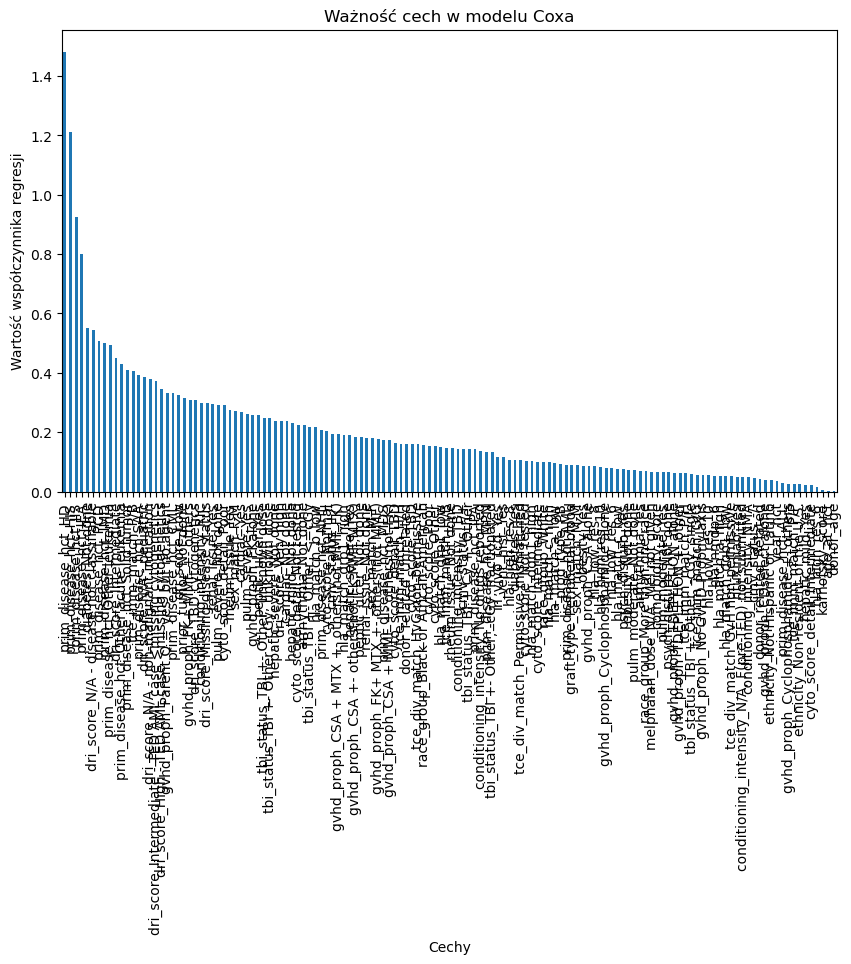

In [498]:
import matplotlib.pyplot as plt

# Pobranie współczynników regresji z modelu
feature_importance = cox_model.params_

# Posortowanie według wartości bezwzględnych (najsilniejsze cechy na górze)
feature_importance = feature_importance.abs().sort_values(ascending=False)

# Wizualizacja
plt.figure(figsize=(10, 6))
feature_importance.plot(kind="bar")
plt.title("Ważność cech w modelu Coxa")
plt.ylabel("Wartość współczynnika regresji")
plt.xlabel("Cechy")
plt.show()

In [158]:
# Sprawdzamy kolumny usunięte wcześniej
for col in columns_to_drop:
    train_df[f"{col}_missing"] = train_df[col].isnull().astype(int)

# Trening modelu z nowymi zmiennymi
cox_model.fit(train_df[features + [f"{col}_missing" for col in columns_to_drop] + ["efs_time", "efs"]],
              duration_col="efs_time", event_col="efs")

# Sprawdzamy ważność zmiennych z brakami
print(cox_model.summary)

KeyError: 'mrd_hct'

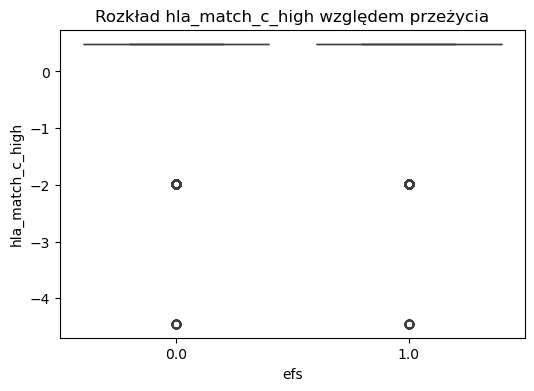

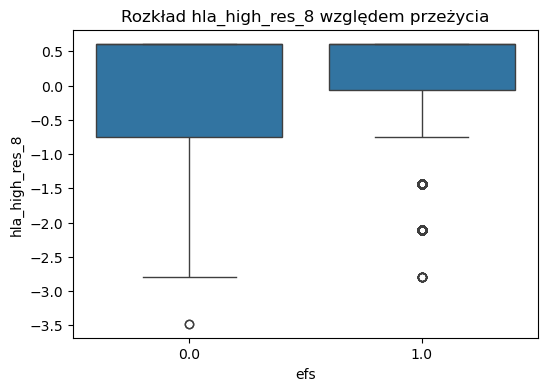

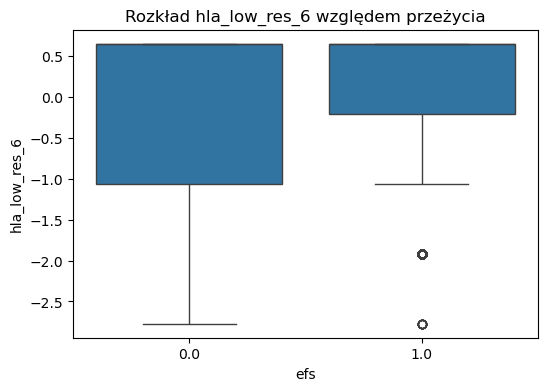

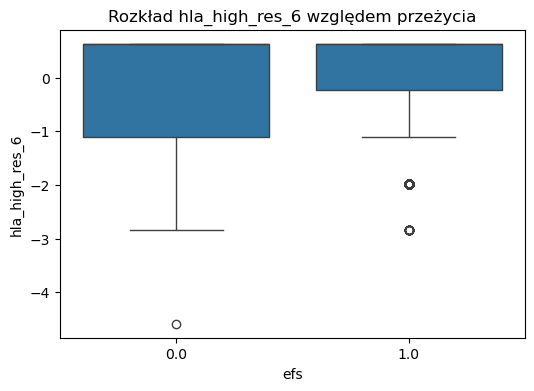

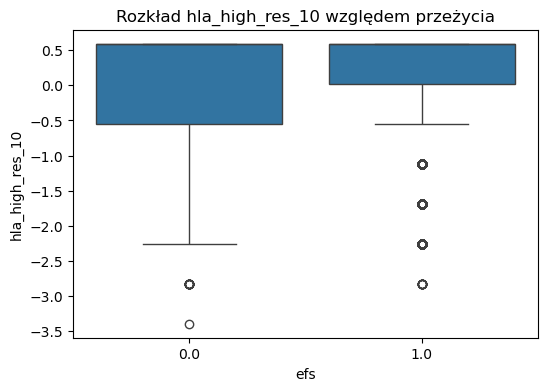

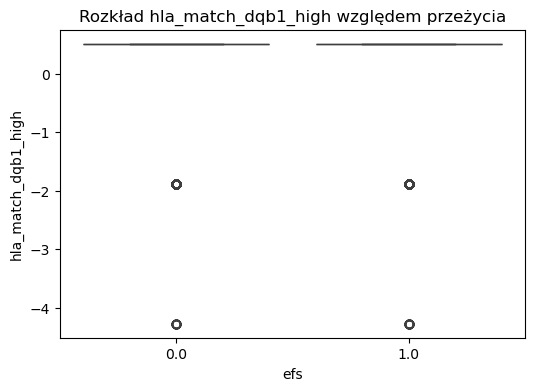

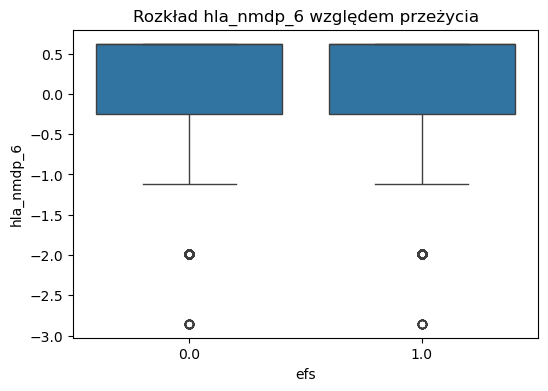

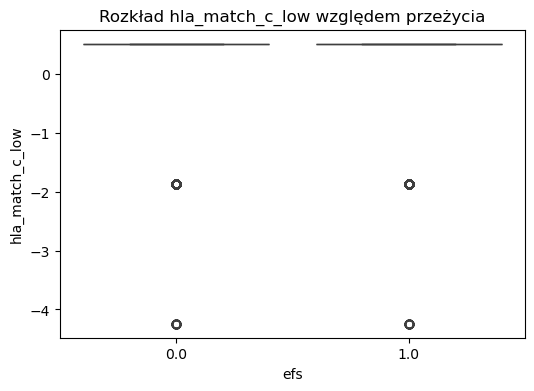

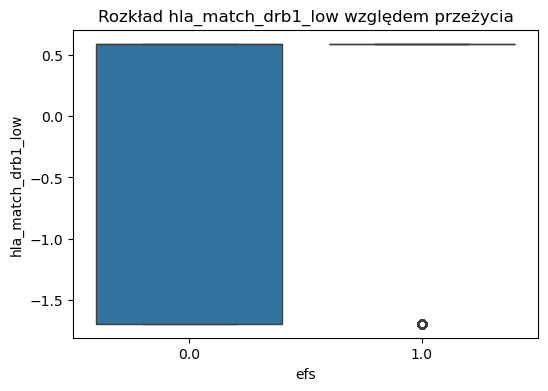

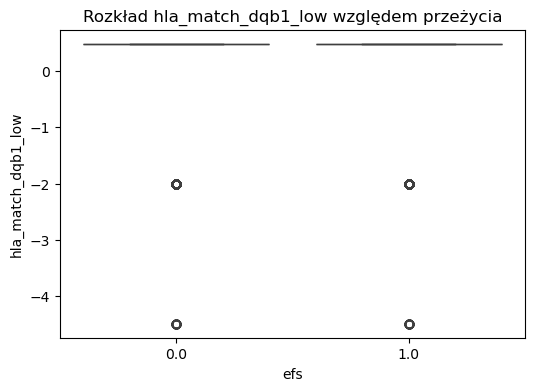

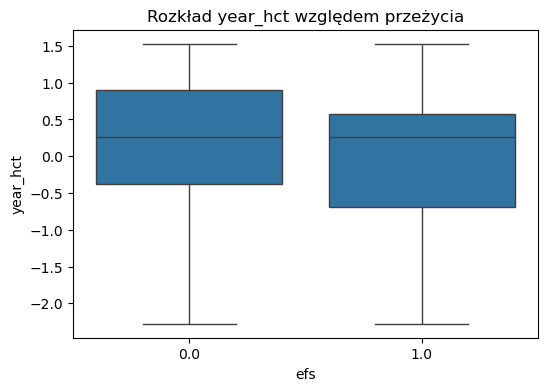

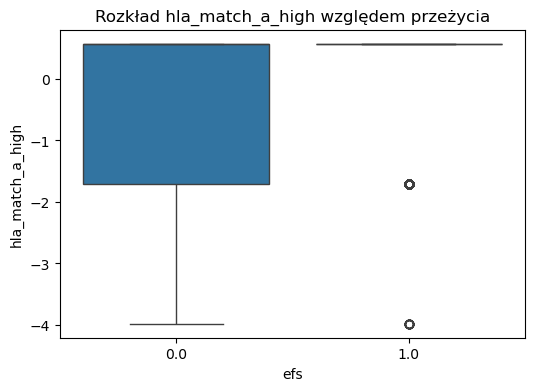

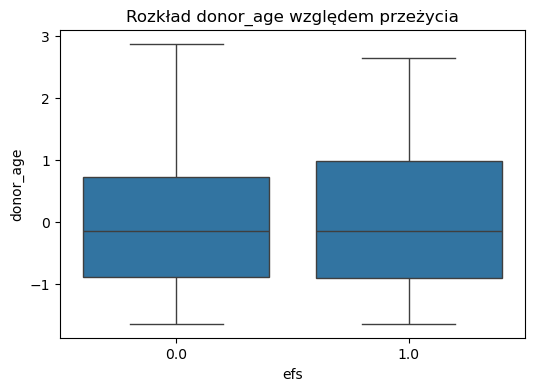

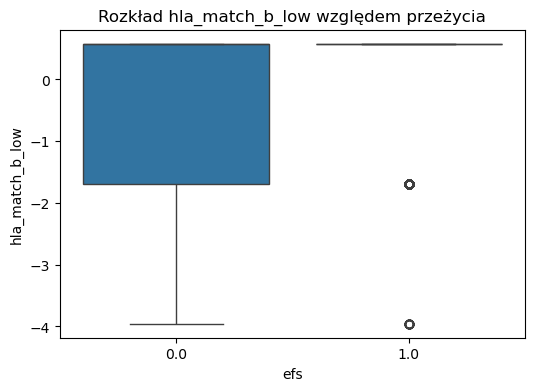

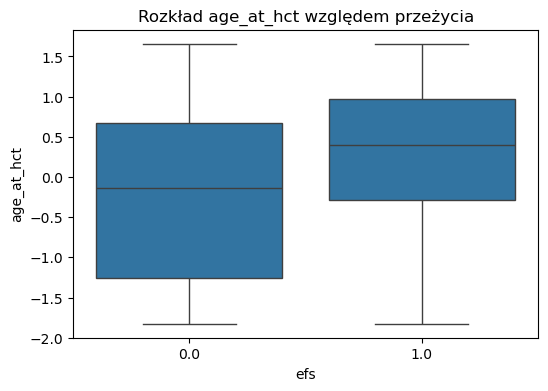

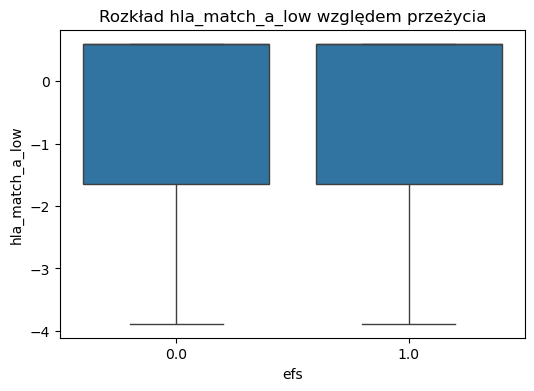

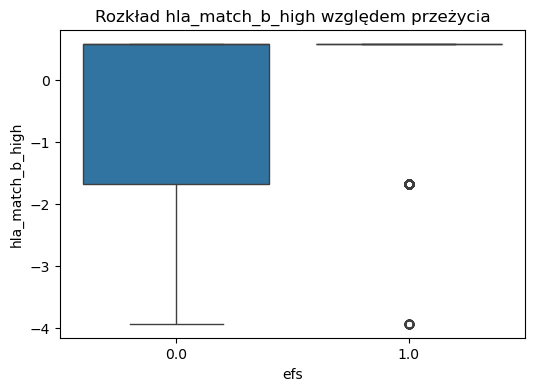

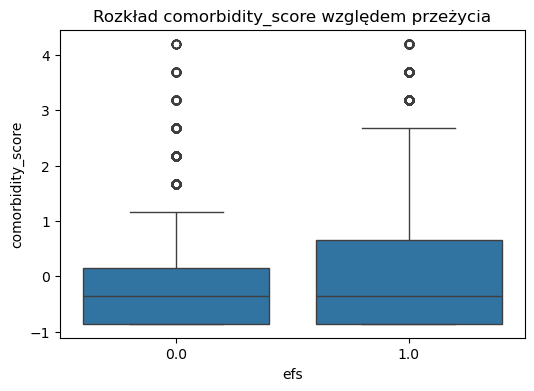

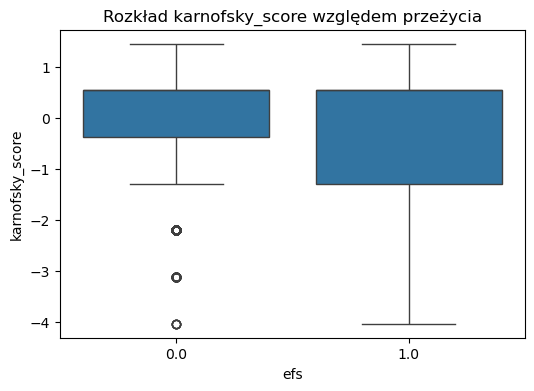

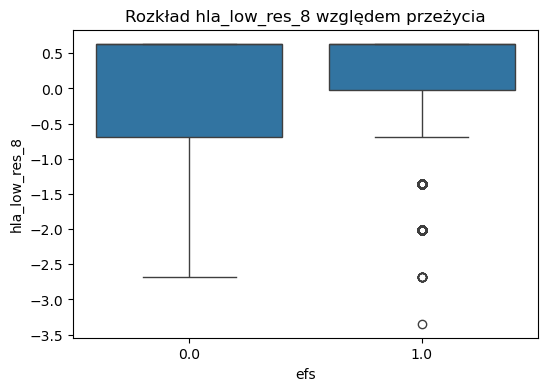

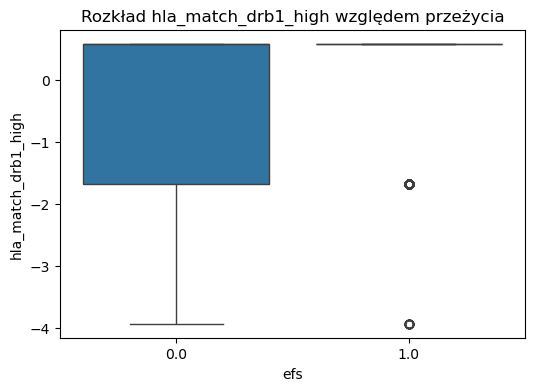

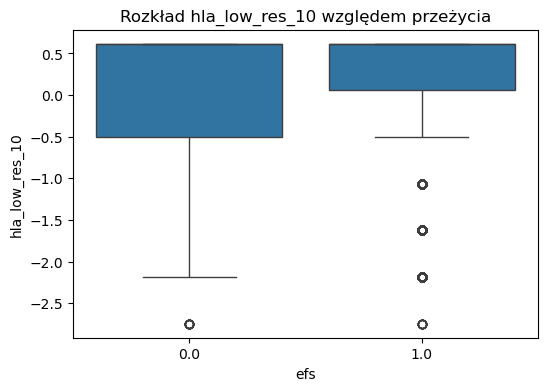

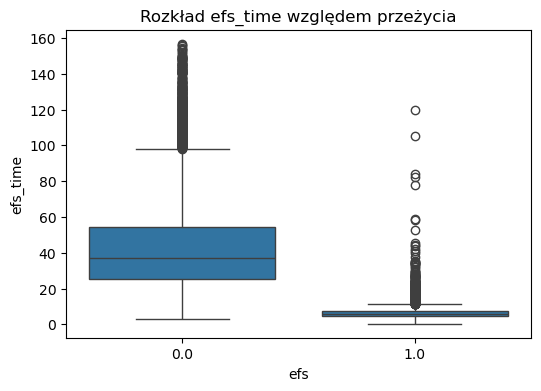

In [309]:
import seaborn as sns
for col in numerical_cols:
    plt.figure(figsize=(6, 4))
    sns.boxplot(x=train_df["efs"], y=train_df[col])
    plt.title(f"Rozkład {col} względem przeżycia")
    plt.show()

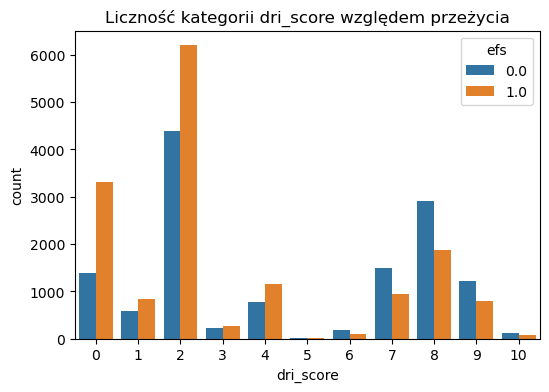

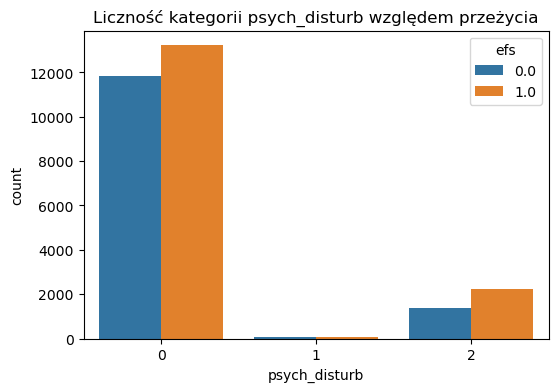

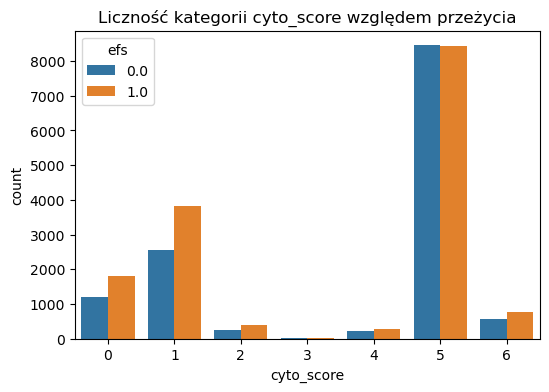

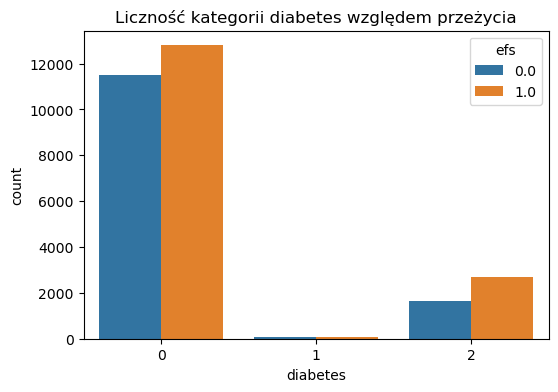

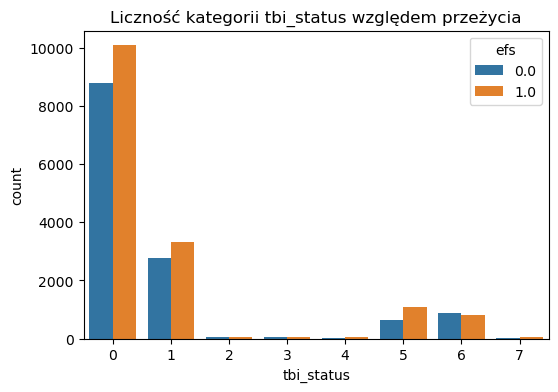

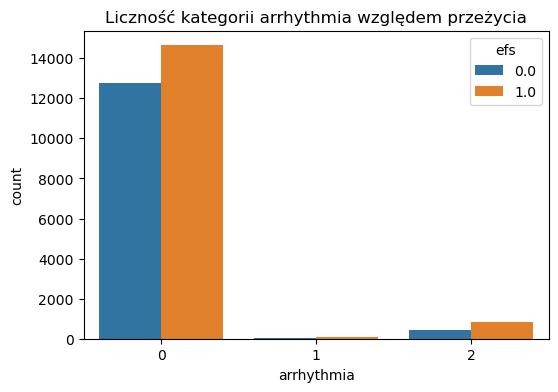

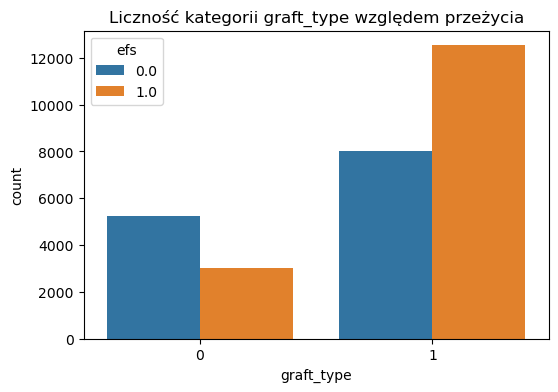

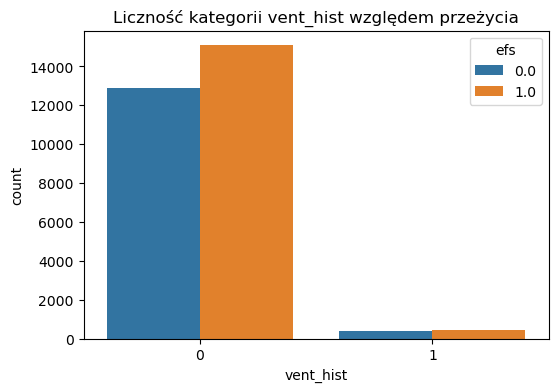

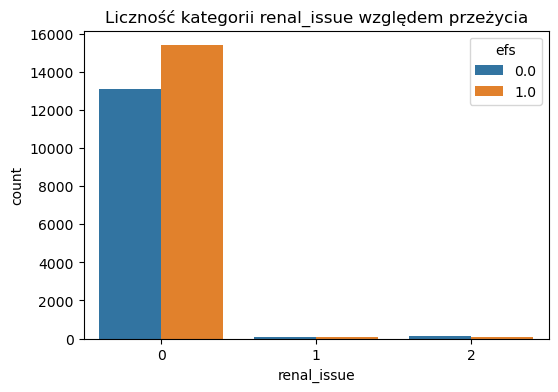

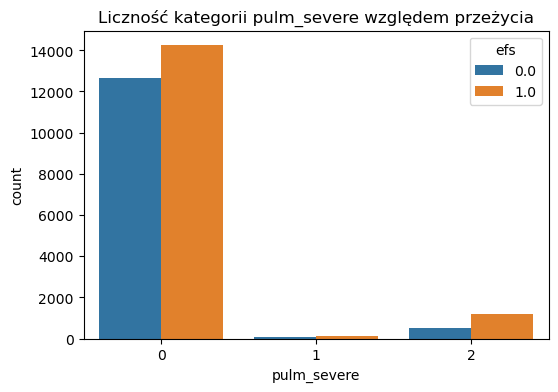

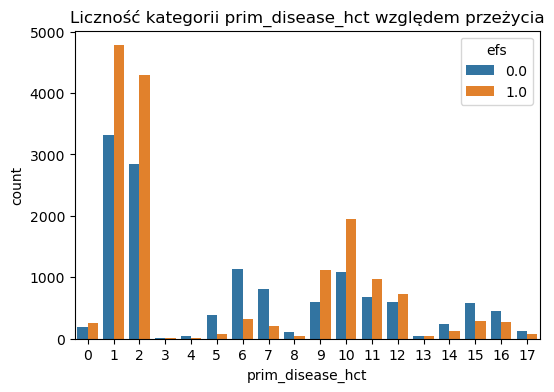

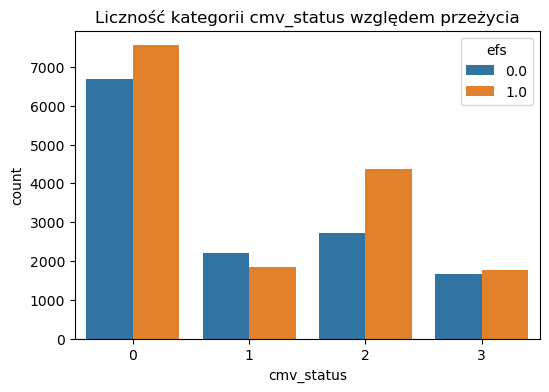

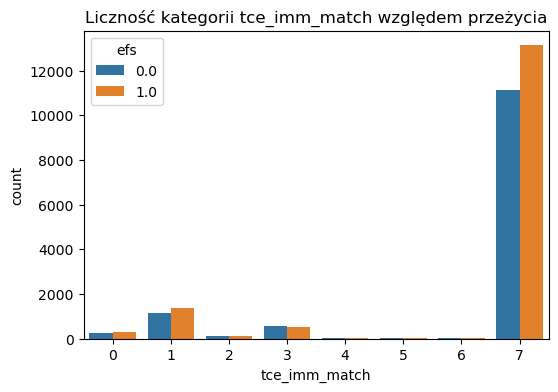

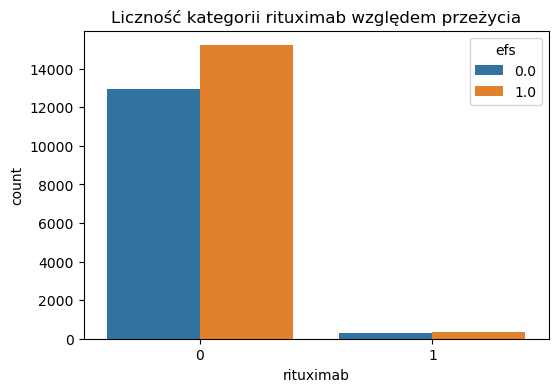

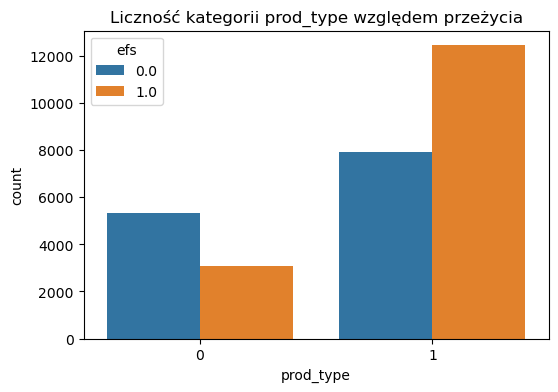

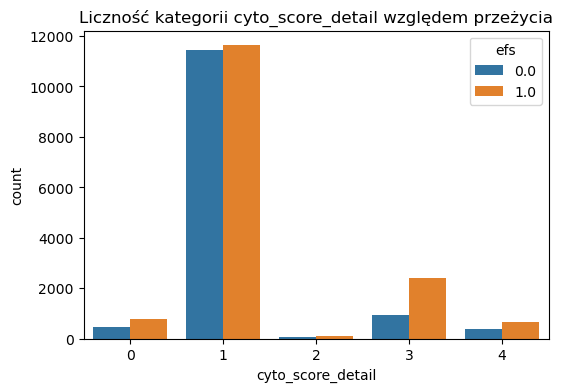

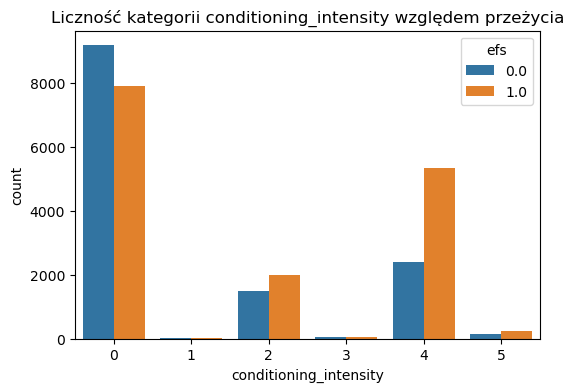

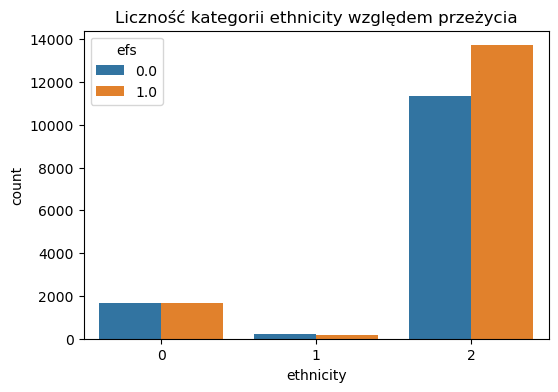

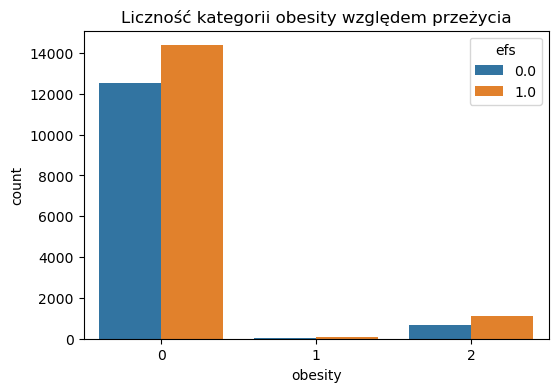

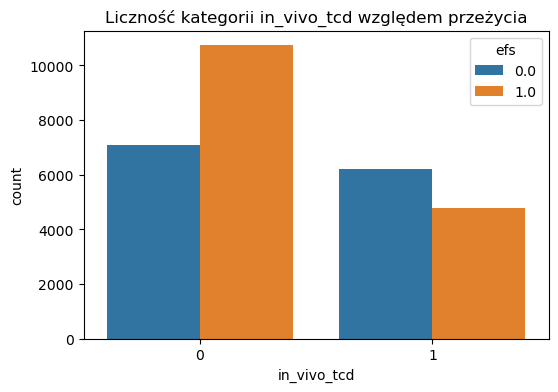

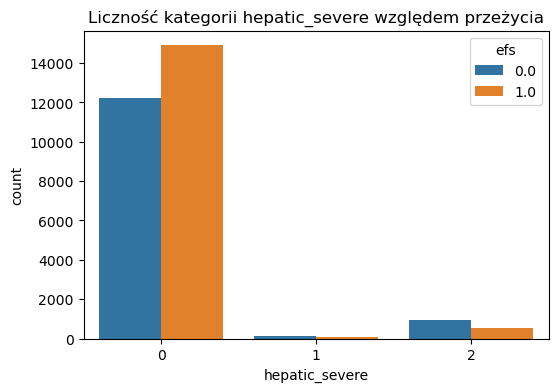

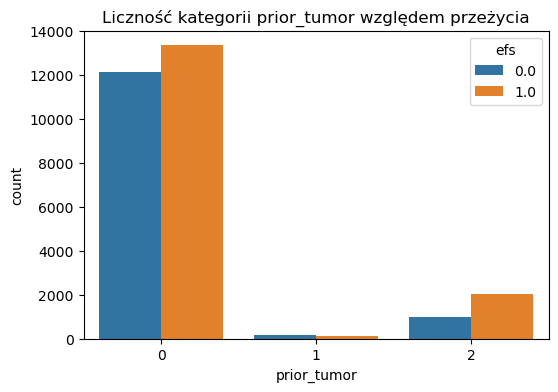

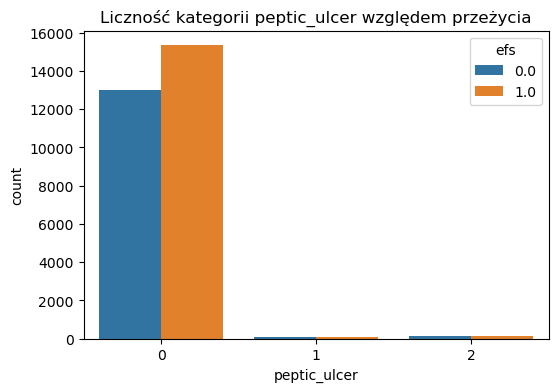

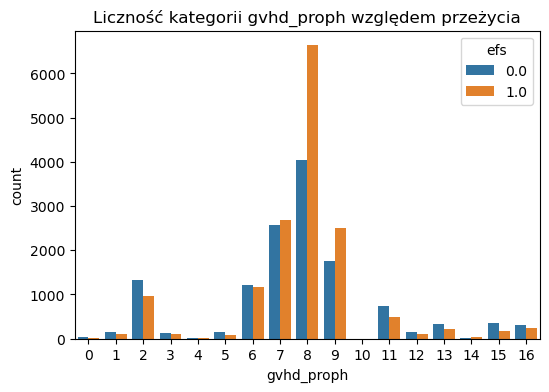

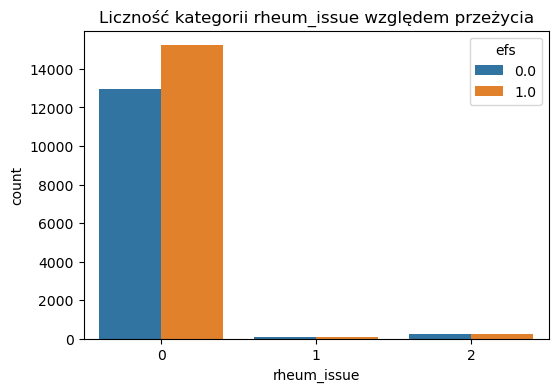

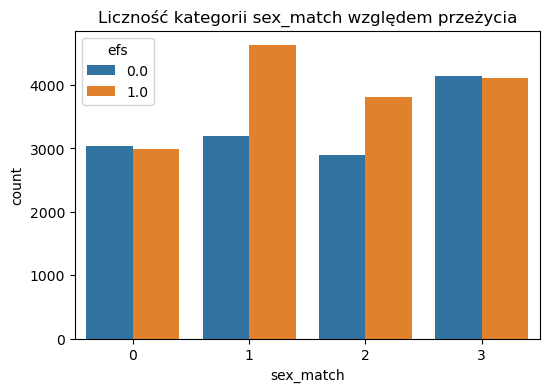

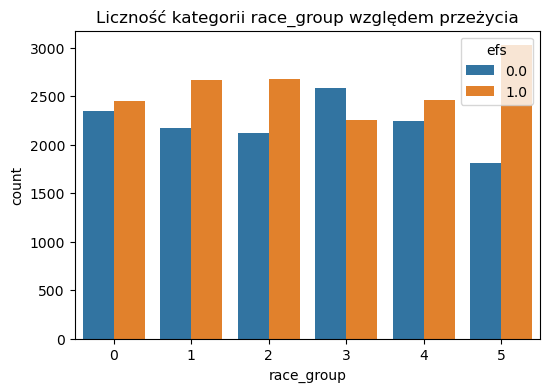

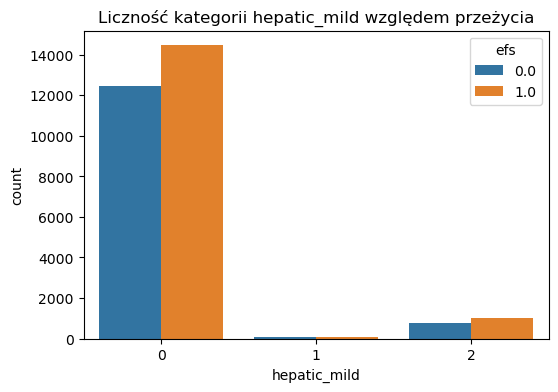

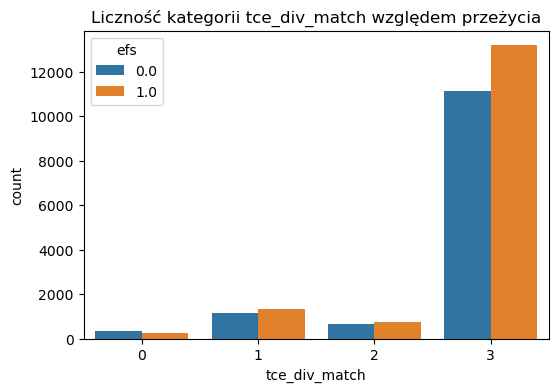

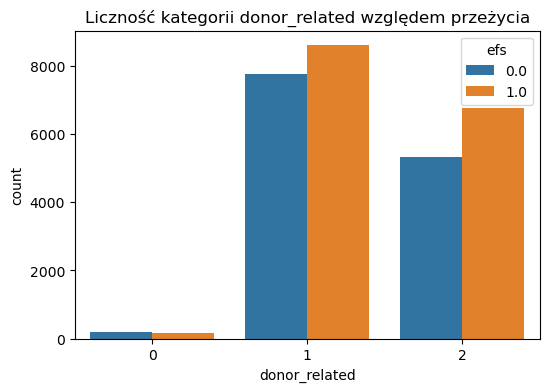

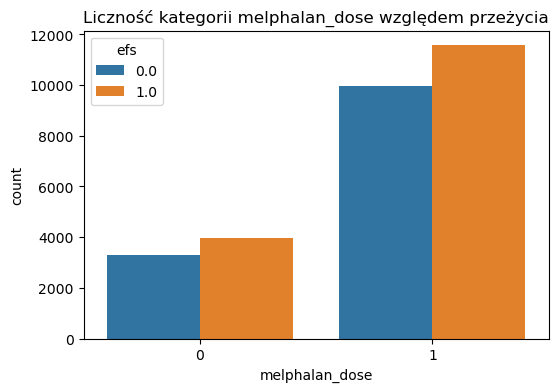

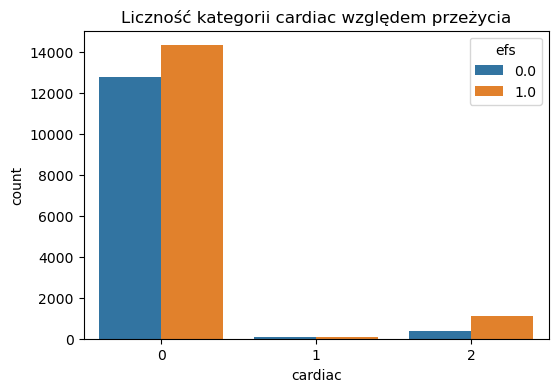

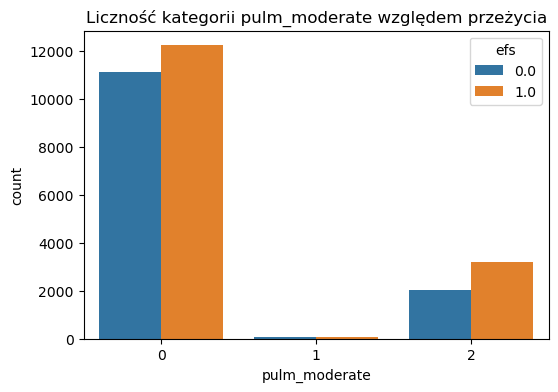

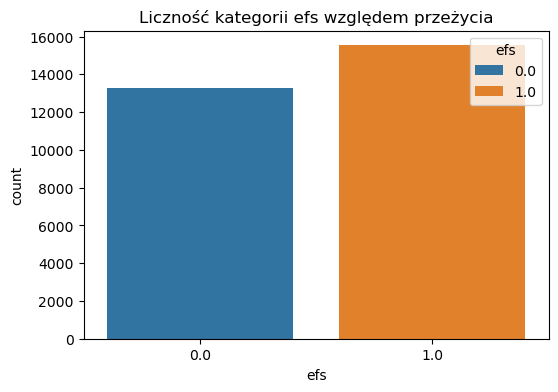

In [310]:
for col in categorical_cols:
    plt.figure(figsize=(6, 4))
    sns.countplot(x=train_df[col], hue=train_df["efs"])
    plt.title(f"Liczność kategorii {col} względem przeżycia")
    plt.show()

In [314]:
for col in numerical_cols:
    plt.figure(figsize=(6, 4))
    sns.kdeplot(train_df[col], hue=train_df["efs_time"], common_norm=False)
    plt.title(f"Rozkład {col} względem czasu przeżycia")
    plt.show()

ValueError: The following variable cannot be assigned with wide-form data: `hue`

<Figure size 600x400 with 0 Axes>

In [315]:
a= features + ["efs_time", "efs"]
a

['dri_score',
 'psych_disturb',
 'cyto_score',
 'diabetes',
 'hla_match_c_high',
 'hla_high_res_8',
 'tbi_status',
 'arrhythmia',
 'hla_low_res_6',
 'graft_type',
 'vent_hist',
 'renal_issue',
 'pulm_severe',
 'prim_disease_hct',
 'hla_high_res_6',
 'cmv_status',
 'hla_high_res_10',
 'hla_match_dqb1_high',
 'tce_imm_match',
 'hla_nmdp_6',
 'hla_match_c_low',
 'rituximab',
 'hla_match_drb1_low',
 'hla_match_dqb1_low',
 'prod_type',
 'cyto_score_detail',
 'conditioning_intensity',
 'ethnicity',
 'year_hct',
 'obesity',
 'in_vivo_tcd',
 'hla_match_a_high',
 'hepatic_severe',
 'donor_age',
 'prior_tumor',
 'hla_match_b_low',
 'peptic_ulcer',
 'age_at_hct',
 'hla_match_a_low',
 'gvhd_proph',
 'rheum_issue',
 'sex_match',
 'hla_match_b_high',
 'race_group',
 'comorbidity_score',
 'karnofsky_score',
 'hepatic_mild',
 'tce_div_match',
 'donor_related',
 'melphalan_dose',
 'hla_low_res_8',
 'cardiac',
 'hla_match_drb1_high',
 'pulm_moderate',
 'hla_low_res_10',
 'efs_time',
 'efs']